The [nested CV](https://github.com/rasbt/model-eval-article-supplementary/blob/master/code/nested_cv_code.ipynb) is implemented according to the [Raschka (2018)](https://arxiv.org/abs/1811.12808).
The [statistical test](https://gist.github.com/jensdebruijn/13e8eeda85eb8644ac2a4ac4c3b8e732) is implemented according to [Boeckhart and Frank (2014)](https://www.cs.waikato.ac.nz/~eibe/pubs/bouckaert_and_frank.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor

import sklearn
print(f"using sklearn version {sklearn.__version__}")
print(f"using numpy version {np.__version__}")

using sklearn version 1.0.1
using numpy version 1.21.4


In [2]:
# generate dataset
n_samples = 250
n_features = 20
X, y = make_regression(n_samples=n_samples,
                       n_features=n_features,
                       n_informative=2,
                       random_state=42,
                       noise=200)

# empirically find out what the minimal amount of seeds is that still result in reproducible results;
# do not seed classifiers during initialization because element of randomness across repetitions is desired?

elasticnet = ElasticNet(random_state=42)
linearsvr = LinearSVR(random_state=42, max_iter=100000)
dummyregr = DummyRegressor()

# set up pipelines
pipe_elasticnet = Pipeline([("std", StandardScaler()),
                           ("elasticnet", elasticnet)])
pipe_linearsvr = Pipeline([("std", StandardScaler()),
                           ("linearsvr", linearsvr)])
pipe_dummyregr = Pipeline([("std", StandardScaler()),
                           ("dummyregr", dummyregr)])

# set up parameter grids for optimization (double underscore preceding parameter is important)
# make sure that l1_ratio for elatic net is > 0.01 (see scikit documentation)
grid_elasticnet = [{"elasticnet__alpha": np.power(2., np.arange(-2, 4)),
                    "elasticnet__l1_ratio": [0.011, 0.5, 1.]}]
grid_linearsvr = [{"linearsvr__C": np.power(10., np.arange(-4, 4))}]
grid_dummyregr = [{"dummyregr__strategy": ["mean", "median"]}]

# set up inner cv of nested cv for parameter tuning
gridcvs = {}
kfolds_inner = 10
inner_nestedcv = KFold(n_splits=kfolds_inner, shuffle=True, random_state=42)

for pgrid, est, name in zip((grid_elasticnet, grid_linearsvr, grid_dummyregr),
                            (pipe_elasticnet, pipe_linearsvr, pipe_dummyregr),
                            ("ElasticNet", "LinearSVR", "Dummy")):
    # refit=True, once optimization is done, refit the entire dataset
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring="neg_mean_squared_error",
                       n_jobs=1,
                       cv=inner_nestedcv,
                       verbose=1,
                       refit=True)
    gridcvs[name] = gcv

In [3]:
repetitions = 100
repetition_seeds = range(repetitions)
kfolds_outer = 5
               
results = {}

for name, gs_est in gridcvs.items():
    
    print(f"optimizing and evaluating {name}")
    
    # pre-allocate data container for saving results of the current comparison
    results[name] = np.zeros((repetitions, kfolds_outer))
    
    for j in repetition_seeds:
               
        print(f"starting repetition {j + 1} with seed {j}")

        # set up outer cv of nested for parameter (i.e., model) evaluation; ensure that for
        # all comparisons, the randomization of folds is identical
        outer_nestedcv = KFold(n_splits=kfolds_outer, shuffle=True, random_state=j)

        # optimize the parameters using the inner_nestedcv (run internally
        # in cross_val_score) and evaluate the performance of the best parameter setting
        # on the outer_nestedcv (also run internally in cross_val_score
               
        # gs_est returns an estimator that uses the optimized parameters found during grid search to
        # predict the labels on the test folds of outer_nestedcv
        cv_score = cross_val_score(gs_est,
                                   X=X,
                                   y=y,
                                   cv=outer_nestedcv,
                                   n_jobs=1)
        print(f"{name} | nested RMSE {cv_score.mean() * 100} +/- {cv_score.std() * 100}") 
        # save the scores of all iterations i of the outer_nestedcv
        results[name][j, :] = cv_score

optimizing and evaluating ElasticNet
starting repetition 1 with seed 0
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
ElasticNet | nested RMSE -3770138.521751565 +/- 718404.4105193983
starting repetition 2 with seed 1
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 candidates, totalling 180 fits
ElasticNet | nested RMSE -3755365.52804061 +/- 1325667.0972363632
starting repetition 3 with seed 2
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 18 cand

In [5]:
from scipy.stats import t
from math import sqrt
from statistics import stdev

def corrected_dependent_ttest(data1, data2, n_training_folds, n_test_folds, alpha):
    n = len(data1)
    differences = [abs(data1[i]-data2[i]) for i in range(n)]
    sd = stdev(differences)
    divisor = 1 / n * sum(differences)
    test_training_ratio = n_test_folds / n_training_folds  
    denominator = sqrt(1 / n + test_training_ratio) * sd
    t_stat = divisor / denominator
    # degrees of freedom
    df = n - 1
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

In [6]:
comparisons = [["ElasticNet", "Dummy"],
               ["LinearSVR", "Dummy"],
               ["ElasticNet", "LinearSVR"]]

# calculate test parameters
nperfold = n_samples // kfolds_outer
ntraininginstances = nperfold * (kfolds_outer - 1)
ntestinstances = nperfold
alpha = 0.05 / len(comparisons)

# test all comparisons for significance
for c in comparisons:
    # select the relevant subset from results
    results_c = {key: value for key, value in results.items() if key in c}
    
    # combine the RMSEs of all folds in one vector of lengts r * k, with r being
    # the number of repetitions and k being the number of folds in the outer cv
    # of the nested cv
    for key, value in results_c.items():
        results_c[key] = np.ravel(value)

    models = list(results_c.keys())
    scores = list(results_c.values())

    t_stat, df, cv, p = corrected_dependent_ttest(scores[0],
                                                  scores[1],
                                                  ntraininginstances,
                                                  ntestinstances,
                                                  alpha)
    print(f"the comparison of {models[0]} and {models[1]} resulted in t = {t_stat}, p = {p}, with a critical value of {cv} and {df} degrees of freedom")

the comparison of ElasticNet and Dummy resulted in t = 1.909657731183115, p = 0.05675040715524804, with a critical value of 2.1339554319760095 and 499 degrees of freedom
the comparison of LinearSVR and Dummy resulted in t = 1.4589354851816543, p = 0.1452120290609622, with a critical value of 2.1339554319760095 and 499 degrees of freedom
the comparison of ElasticNet and LinearSVR resulted in t = 2.048513318742549, p = 0.04103236406439903, with a critical value of 2.1339554319760095 and 499 degrees of freedom


repetition 1 with seed 0
[ 0  1  3  4  5  6  7  8  9 12 14 15 16 18 19 20 21 23 25 29] [ 2 10 11 13 17 22 24 26 27 28]
[ 0  2  3  7  9 10 11 12 13 15 17 18 19 21 22 24 25 26 27 28] [ 1  4  5  6  8 14 16 20 23 29]
[ 1  2  4  5  6  8 10 11 13 14 16 17 20 22 23 24 26 27 28 29] [ 0  3  7  9 12 15 18 19 21 25]
repetition 2 with seed 1
[ 0  1  2  4  5  6  7  8  9 11 12 13 15 16 18 23 25 27 28 29] [ 3 10 14 17 19 20 21 22 24 26]
[ 0  3  5  8  9 10 11 12 14 15 16 17 19 20 21 22 24 26 28 29] [ 1  2  4  6  7 13 18 23 25 27]
[ 1  2  3  4  6  7 10 13 14 17 18 19 20 21 22 23 24 25 26 27] [ 0  5  8  9 11 12 15 16 28 29]
repetition 3 with seed 2
[ 2  4  5  7  8 10 11 12 13 15 16 17 18 22 24 25 26 27 28 29] [ 0  1  3  6  9 14 19 20 21 23]
[ 0  1  3  6  7  8  9 11 13 14 15 18 19 20 21 22 23 24 26 29] [ 2  4  5 10 12 16 17 25 27 28]
[ 0  1  2  3  4  5  6  9 10 12 14 16 17 19 20 21 23 25 27 28] [ 7  8 11 13 15 18 22 24 26 29]


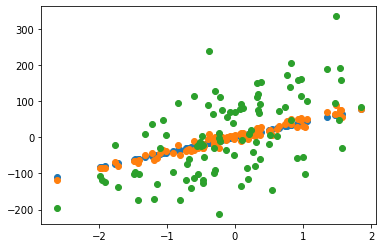

In [7]:
################################################
# self-contained, minimal, reproducible examples
################################################

# repeated k-fold
#################

X, y = make_regression(n_samples=30, n_features=2)

repetitions = 3
repetition_seeds = range(repetitions)

for j in repetition_seeds:
    
    cv = KFold(n_splits=3, random_state=j, shuffle=True)
    
    print(f"repetition {j + 1} with seed {j}")
    
    for trainidx, testidx in cv.split(X):
        print(trainidx, testidx)
        
# noise demo
############

for noise in [0, 10, 100]:
    X, y = make_regression(n_samples=100,
                           n_features=1,
                           random_state=42,
                           noise=noise)

    plt.scatter(X, y)